<font color = blue><font size = 6> 실험설명 </font></font><br>
Pytorch의 모델 구성의 기본을 study하면서 DLinear를 implementation한 깃허브를 참고해서 이해하고 실험에 적용시켜본다 여기서 진행할 실험은
<font color = blue>정답 값이 들어올 때 훈련없이 그 정답 값을 이용해서 다음 값을 예측한 것이다</font>

[Reference]<br>
https://github.com/cure-lab/LTSF-Linear/blob/main/models/DLinear.py <br>
https://anweh.tistory.com/21

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data = pd.read_csv('../data/5.csv')
data

,a,b,values,c,d
0,0,2018-07-25 00:00:00,92408,26971036,177711644
1,0,2018-07-25 00:01:00,92150,26948190,220370286
2,0,2018-07-25 00:02:00,94896,26238222,188035073
3,0,2018-07-25 00:03:00,92694,26087970,191997884
4,0,2018-07-25 00:04:00,93674,25314568,169497214
...,...,...,...,...,...
38875,0,2018-08-20 23:55:00,81521,23637112,138239574
38876,0,2018-08-20 23:56:00,83092,24617816,164460450
38877,0,2018-08-20 23:57:00,84873,25101336,173568370
38878,0,2018-08-20 23:58:00,81736,24181689,157334718


In [4]:
data.drop(columns=['a','b','c','d'],inplace=True)
data

,values
0,92408
1,92150
2,94896
3,92694
4,93674
...,...
38875,81521
38876,83092
38877,84873
38878,81736


In [6]:
import configparser
import os
config = configparser.ConfigParser()
config['1step-DLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('1step-DLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'1step-DLinear')

['/hdd_1/sjlee/Model_Implementation/1step-DLinear']

In [7]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [8]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)

        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [9]:
class Model(nn.Module):
    "Decomposition - Linear"
    def __init__(self,configs): # 내가 만든 configure module file
        super(Model,self).__init__()
        self.device = torch.device('cuda:0')
        self.seq_len = int(configs['1step-DLinear']['seq_len']) # configure의 sequence length
        self.pred_len = int(configs['1step-DLinear']['pred_len']) # configure의 prediction length1
        
        # Decomposition Kernel Size
        kernel_size = 25
        self.decomposition = series_decomp(kernel_size)
        # residual과 moving_average 값을 받기 위한 decomposition model
        self.individual = configs['1step-DLinear']['individual'] # 1) 특성각각에 대해 별도의 layer를 둘것이냐의여부 이고
        self.channels = int(configs['1step-DLinear']['enc_in']) # 2) 이때 특성의개수
        
        if self.individual==True: # 특성 각각에 별도의 layer를 두자고 하면 -> Layer를 담아놓을 list가 필요함
            self.Linear_Seasonal = nn.ModuleList() # 모듈을 담아놓는 리스트 파이썬의 리스트처럼 인덱스로 접근 가능하다
            self.Linear_Trend = nn.ModuleList()
            
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))
        else: # 특성 각각에 별도의 layer를 두지 말자고 하면 하나씩의 Layer만 있으면 됨
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
            
    def forward(self,x):
        
        # x의 size는 [Batch, Input_length, Channel]
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
        seasonal_init,trend_init = seasonal_init.cpu(), trend_init.cpu() # 새로로 펼친걸 가로로 늘림
        # batch,input_size, sequence_length ex> tensor([[[1.6667, 2.0000, 2.6667, 3.6667],[1.6667, 2.0000, 2.6667, 3.6667]]])
        
        if self.individual==True:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],
                                              dtype = seasonal_init.dtype).to(seasonal_init.device)
                # seasonal_output을 저장할 Tensor를 만듦 Tip> ones도 비슷함
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),
                                            self.pred_len],dtype = trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):# feature의 갯수만큼 for문을 돌림 feature 각각에 대해서 linear layer에 투입
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                    # 위에서 seasonal init을 batch, input_size, sequence length로 바꿈 여기서 input size가 의미하는 바가 사실 
                    # feature의 갯수임 -> 따라서 각 피처마다 Linear Layer가 따로 있고 하나의 피처의 sequence length만큼의 데이터를 집어넣은후 학습하는 구조
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)    
            trend_output = self.Linear_Trend(trend_init)
        
        x = seasonal_output + trend_output
        return x.permute(0,2,1).to(self.device) # batch size, output_length(not sequence_length Layer를 돌면서 크기가 바뀜), channel(feature_size)로 변경해서 return

In [10]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [11]:
sequence_length = 1440
pred_len = 1
split= 1440
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

/tmp/ipykernel_201744/197408478.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [12]:
x_seq.size()

torch.Size([36000, 1, 1440])

In [14]:
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config)
optimizer = Adam(model.parameters(),1e-5)
criterion = SMAPE()

In [15]:
for a,b in training:
    print(a,b)
    print(a.size(),b.size())
    break

tensor([[[92408., 92150., 94896.,  ..., 98364., 96225., 98629.]],

        [[92150., 94896., 92694.,  ..., 96225., 98629., 98278.]],

        [[94896., 92694., 93674.,  ..., 98629., 98278., 97686.]],

        ...,

        [[77266., 77101., 74753.,  ..., 79546., 79786., 78445.]],

        [[77101., 74753., 72821.,  ..., 79786., 78445., 76820.]],

        [[74753., 72821., 74505.,  ..., 78445., 76820., 77895.]]],
       device='cuda:0') tensor([[[98278.]],

        [[97686.]],

        [[95846.]],

        [[96200.]],

        [[94891.]],

        [[95600.]],

        [[94492.]],

        [[95053.]],

        [[92533.]],

        [[91418.]],

        [[89602.]],

        [[88224.]],

        [[88790.]],

        [[89670.]],

        [[90360.]],

        [[88702.]],

        [[89717.]],

        [[88490.]],

        [[85032.]],

        [[86133.]],

        [[87663.]],

        [[84890.]],

        [[80210.]],

        [[83160.]],

        [[80587.]],

        [[83444.]],

        [[7954

<font color =blue> zero_grad()의 이해 </font><br>
parameter들을 업데이트하는데,
한 루프에서 업데이트를 위해 loss.backward()를 호출하면 각 파라미터들의 .grad 값에 변화도가 저장이 된다.

이후 다음 루프에서 zero_grad()를 하지않고 역전파를 시키면 이전 루프에서 .grad에 저장된 값이 다음 루프의 업데이트에도 간섭을 해서 원하는 방향으로 학습이 안된다고 한다.

-> 쉽게 이해하자면 역전파를 보낼때마다 초기화를 시켜줘야하는데 이전값이 영향을 주고 있는 셈

In [16]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:

        out = model(seq)
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
        
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')        

smape 37.72178522588478 %
smape 17.97713679145608 %
smape 18.604074746742842 %
smape 17.314997978756825 %
smape 17.19401145283547 %
smape 15.335860618535015 %
smape 14.812363159656524 %
smape 14.608308566485842 %
smape 14.191345006600024 %
smape 13.910638437461524 %
smape 13.87265182957053 %
smape 14.014878670581513 %
smape 13.208888650519981 %
smape 13.62872695285413 %
smape 13.074090137912167 %
smape 13.526641765857736 %
smape 14.151864450300733 %
smape 13.362901184873449 %
smape 13.185773773077461 %
smape 14.910974891318215 %
smape 13.459835938612619 %
smape 13.101709039716258 %
smape 12.297895533550117 %
smape 12.852478774968121 %
smape 12.415014755353331 %
smape 12.943728252541689 %
smape 13.261562695064477 %
smape 11.956236834244596 %
smape 11.91264178653558 %
smape 13.29953107730382 %
smape 11.820160419286953 %
smape 12.875684156103267 %
smape 13.53987279670934 %
smape 12.572599313532312 %
smape 12.32867736712926 %
smape 12.384208170904055 %
smape 12.243439089175729 %
smape 11.3

파이토치 모델 seed박는법 알아보기

In [17]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []
for idx in range(split):
    running_loss = 0.0
    start = time.time()
    if idx == 0:
        new_train = torch.FloatTensor(
            [X.iloc[-sequence_length:].values]
        ).view(1,1,sequence_length).to(device)
                
    else:
        new_train = torch.FloatTensor(
            [pd.concat([X.iloc[-sequence_length+idx:],target.iloc[0:idx]],axis=0,ignore_index=True).values]
            ).view(1,1,sequence_length).to(device)
    with torch.no_grad():
        model.eval()
        out = model(new_train) # 예측완료
        end = time.time()
        pred_list.append(out.cpu().view(1).item())
        time_list.append(end-start)

In [18]:
len(pred_list)

1440

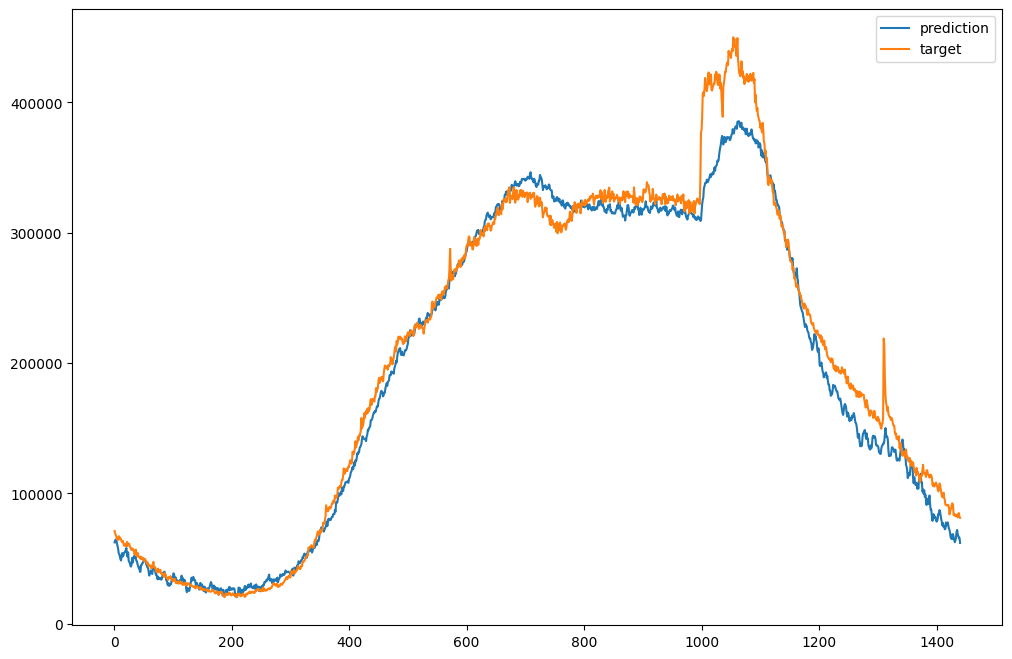

In [20]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,1441),pred_list,label='prediction')
axes.plot(np.arange(1,1441),target,label='target')
axes.legend()

In [21]:
np.array(pred_list)

array([62342.21484375, 64088.12890625, 64535.2578125 , ...,
       65607.25      , 65966.359375  , 61940.22265625])

In [22]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
target

array([[71104],
       [69093],
       [67786],
       ...,
       [84873],
       [81736],
       [81236]])

In [419]:
print(FloatTensor(np.array(pred_list)).size(),FloatTensor(target).size())

torch.Size([1440]) torch.Size([1440, 1])


In [35]:
score=SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target))*100

In [37]:
print('score',score.item(),'%')

score 8.163675308227539 %


In [30]:
new_pred_list=[i+15000 for i in pred_list]# 단순히 sliding된건 아닌지 확인하기 위해

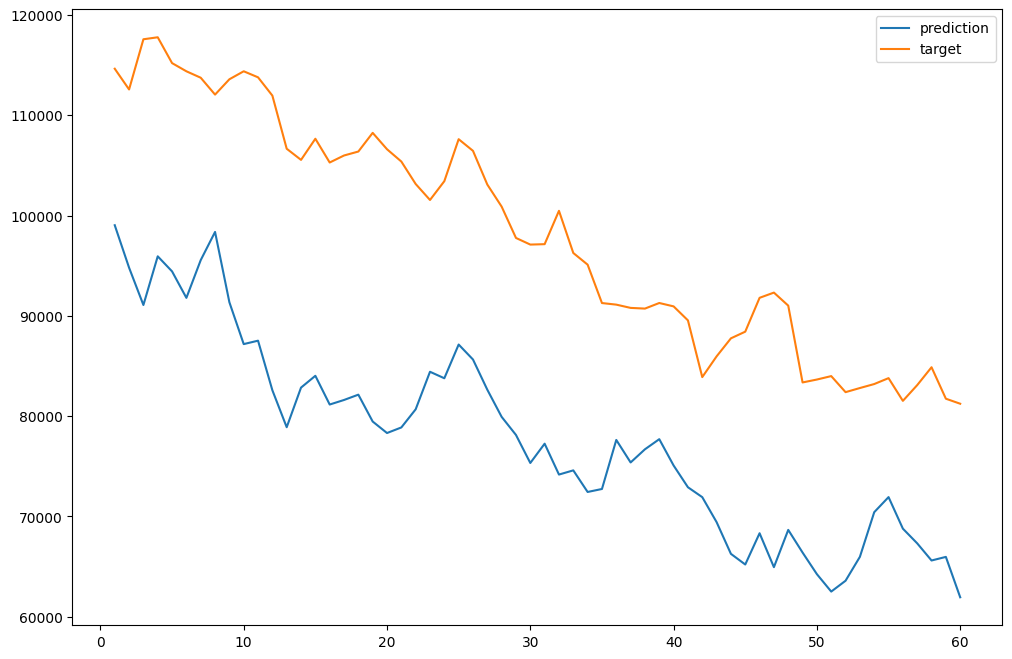

In [31]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

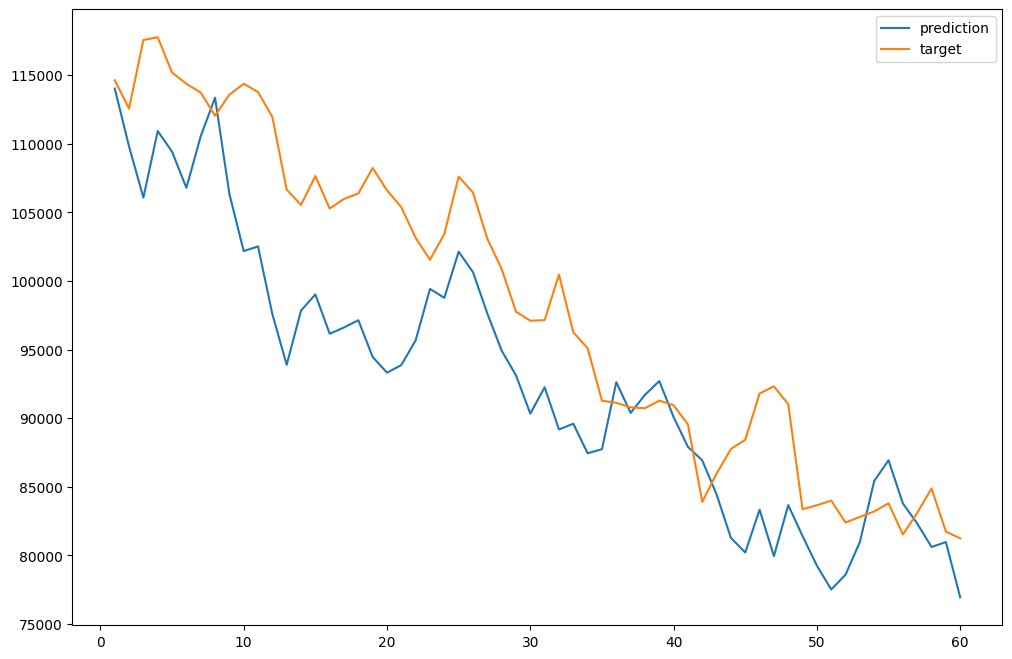

In [32]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),new_pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

<font color =blue> 단순 sliding은 아닌듯 하다 </font>

<font color = blue><font size = 6> Conclusion </font></font><br>
이번 결과는 1step마다 예측을 진행한 결과이다 현재 목표는 바로 다음시점(여기서는 1분후)를 잘 예측하는 것이 목적이다 그런 측면에서 본다면 이전까지의 데이터에 대한 의존성이 큰 문제가 되지는 않지만 다른 말로 하자면 데이터가 제공되지 않는 구간이 생긴다면 예측에 오류가 생길것이다 이는 곧 데이터가 제공되지 않고 나의 이전 예측으로 다음시점을 예측하는데에는 불리하다는 말이 된다<br><font color = blue>
하지만 현재의 가정은 데이터가 계속해서 제공이 될때 바로 앞을 예측하는 것이기 때문에 괜찮다</font>